In [166]:
import pandas as pd
import numpy as np

!wget -O laptops.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2025-09-24 10:35:06--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.02s   

2025-09-24 10:35:06 (18.2 MB/s) - ‘laptops.csv’ saved [298573/298573]



In [167]:
data = pd.read_csv('laptops.csv')

In [168]:
df = pd.DataFrame(data)
df.dtypes

Laptop           object
Status           object
Brand            object
Model            object
CPU              object
RAM               int64
Storage           int64
Storage type     object
GPU              object
Screen          float64
Touch            object
Final Price     float64
dtype: object

In [169]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

features = ['ram','storage','screen']
target = ['final_price']

## __Question 1__
### There's one column with missing values. What is it?

In [170]:
df.isnull().sum()

laptop             0
status             0
brand              0
model              0
cpu                0
ram                0
storage            0
storage_type      42
gpu             1371
screen             4
touch              0
final_price        0
dtype: int64

__ANSWER:__ From the columns selected in block [5], screen is missing values.

## __Question 2__
### What's the median (50% percentile) for variable 'ram'?

In [171]:
df['ram'].median()

16.0

__ANSWER:__ 16 is the median value of 'ram.'

## __Question 3__
We need to deal with missing values for the column from Q1. <br>
We have two options: fill it with 0 or with the mean of this variable.<br>
Try both options. For each, train a linear regression model without regularization using the code from the lessons.<br>
For computing the mean, use the training only!<br>
Use the validation dataset to evaluate the models and compare the RMSE of each option.<br>
Round the RMSE scores to 2 decimal digits using round(score, 2)<br>
### Which option gives better RMSE?
Options: With 0 / With mean / Both are equally good

In [172]:
np.random.seed(42)

def tvt_data(df):
    n = len(df)
    
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_shuffled = df.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    return df_train, df_val, df_test

df_train, df_val, df_test = tvt_data(df)

In [173]:
def set_target(df_train, df_val, df_test):
    y_train_orig = df_train.final_price.values
    y_val_orig = df_val.final_price.values
    y_test_orig = df_test.final_price.values
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    return y_train, y_val, y_test

y_train, y_val, y_test = set_target(df_train, df_val, df_test)

In [174]:
base = ['ram','storage','screen']

In [175]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [176]:
mean = df_train['screen'].mean()
mean

np.float64(15.163534416086618)

In [181]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df_num = df[features]
    df_num = df_num.fillna(15.16)
    X = df_num.values
    return X

In [182]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [183]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [184]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred).round(2))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred).round(2))

train: 602.18
validation: 600.26


Replace nan values with 0:<br>
train: 602.39<br>
validation: 597.36

Replace nan values with mean (15.13):<br>
train: 602.18<br>
validation: 600.26

## __Question 4__
Now let's train a regularized linear regression.<br>
For this question, fill the NAs with 0.<br>
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].<br>
Use RMSE to evaluate the model on the validation dataset.<br>
Round the RMSE scores to 2 decimal digits.<br>
## Which r gives the best RMSE?
If there are multiple options, select the smallest r.<br>
Options: 0/ 0.01/ 1/ 10/ 100

In [185]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [186]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.01, 1, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred).round(3))

     0 600.264
  0.01 600.257
     1 599.672
    10 598.069
   100 597.606


__Answer:__   r=1 gives the best rmse at a precision 3 decimal places.

## __Question 5__
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.<br>
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].<br>
For each seed, do the train/validation/test split with 60%/20%/20% distribution.<br>
Fill the missing values with 0 and train a model without regularization.<br>
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.<br>
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.<br>
Round the result to 3 decimal digits (round(std, 3))<br>
## What's the value of std?
19.176/ 29.176/ 39.176/ 49.176

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='final_price', ylabel='Count'>

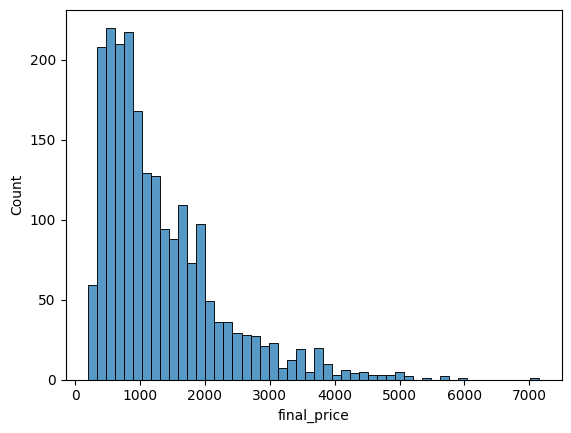

In [188]:
sns.histplot(df.final_price, bins=50)

In [189]:
def model(seed):
    np.random.seed(seed)
    data = pd.read_csv('laptops.csv')
    df = pd.DataFrame(data)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    df_train,df_val,df_test = tvt_data(df)
    y_train, y_val, y_test = set_target(df_train, df_val, df_test)
    base = ['ram','storage','screen']
    
    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    
    y_pred = w_0 + X_train.dot(w)
    rmse_train = rmse(y_train, y_pred).round(3)
    #print('train:', rmse_train )
    
    X_val = prepare_X(df_val)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred).round(3)
    #print('validation:', rmse_val)
    return rmse_train.item(), rmse_val.item()

    

In [190]:
scores = []
score = model(0)

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    score = model(seed)
    scores.append(score[1])

In [193]:
np.std(scores).round(3).item()

28.949

__Answer:__ My standard dev is closest to 29.176.

## __Question 6__
Split the dataset like previously, use seed 9.<br>
Combine train and validation datasets.<br>
Fill the missing values with 0 and train a model with r=0.001.<br>
## What's the RMSE on the test dataset?
598.60/ 608.60/ 618.60/ 628.60

In [192]:
def model_reg(seed, reg):
    np.random.seed(seed)
    data = pd.read_csv('laptops.csv')
    df = pd.DataFrame(data)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    df_train,df_val,df_test = tvt_data(df)
    y_train, y_val, y_test = set_target(df_train, df_val, df_test)
    base = ['screen']

    df_full_train = pd.concat([df_train, df_val])
    df_full_train = df_full_train.reset_index(drop=True)
    X_full_train = prepare_X(df_full_train)    

    y_full_train = np.concatenate([y_train,y_val])

    w_0, w = train_linear_regression_reg(X_full_train, y_full_train, reg)
    
    X_test = prepare_X(df_test)
    y_pred = w_0 + X_test.dot(w)
    
    return y_test, y_pred

y_test, y_pred = model_reg(9, .001)
rmse(y_test, y_pred).item()

611.7362444844765

__Answer:__ My rmse is closest to 608.60.